In [1]:
# This script will run an analysis of population growth for all of Canada
# using our preprocessed Canadian census data

# Typical data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

# Additional helper libraries
import textwrap
import time
from joblib import dump # For saving the model after training

In [2]:
# For visualization of feature importances, let's include this stacked bubble plot
# algorithm from https://matplotlib.org/stable/gallery/misc/packed_bubbles.html
# It has been modified a little to account for long feature names

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center', fontsize=6)


In [3]:
# Load the data

dataSetName = 'Canada'
census2016 = pd.read_csv(f'../processedData/processed_{dataSetName}_2016.csv')
census2021 = pd.read_csv(f'../processedData/processed_{dataSetName}_2021.csv')

In [4]:
# We only need the GEO_NAME for cross referencing, the population count for training,
# and the province for handling duplicate community names
trimmed2021 = census2021[['GEO_NAME', 'Province', 'Population, 2021']]
# Drop any rows with missing population data
trimmed2021 = trimmed2021.dropna()
# Sort the data by community name
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')
# Take a subset of the 2021 data that matches 
# the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
# We will need to use a merge rather than a simple isin() because we need to match across multiple columns
trimmed2021 = trimmed2021.merge(census2016[['GEO_NAME', 'Province']], on=['GEO_NAME', 'Province'], how='inner')

# Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
trimmed2016 = census2016.merge(trimmed2021[['GEO_NAME', 'Province']], on=['GEO_NAME', 'Province'], how='inner')

# As a last step before we are done, we need to sort the dataframes by the community name so that the
# data is in the same order for both datasets
trimmed2016 = trimmed2016.sort_values(by='GEO_NAME')
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')

print(f'Trimmed 2016 data Shape: {trimmed2016.shape}')
print(f'Trimmed 2021 data Shape: {trimmed2021.shape}')


Trimmed 2016 data Shape: (3405, 216)
Trimmed 2021 data Shape: (3405, 3)


In [5]:
# Model setup and training
# We will need to train more than once, so we will create a function to handle the process

def setupAndTraining(features, populationTargets, numTrees = 100, minSamplesLeaf = 1):
    '''
    This function will set up a random forest regressor model,
    traing it, test the prediction capabailities against the validation set,
    and return the model and relevant data for further analysis

    Args:
    features: The features to use for training
    populationTargets: The target variable for training
    numTrees: The number of trees to use in the random forest regressor
    minLeafSamples: The minimum number of samples to use for a leaf node in the random forest
    '''
    # Define the features and target variable
    X = features.drop(columns=['GEO_NAME', 'Province'])
    y = populationTargets['Population, 2021']

    # Split the training data into training and validation sets
    XTrain, XVal, yTrain, yVal = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=42)

   # The features we are using are entirely numeric, so only a numeric transformer is requried
    numericTransformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Using most frequent to avoid outliers skewing the data
        ('scaler', StandardScaler())
    ])

    # Setting up the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numericTransformer, X.columns)
        ]
    )

    # We'll use a random forest regressor for the model
    regressor = RandomForestRegressor(n_estimators=numTrees, min_samples_leaf= minSamplesLeaf, random_state=42)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Train the model
    
    print('Training model...')
    trainingStart = time.time()
    model.fit(XTrain, yTrain)
    trainingEnd = time.time()
    print(f'Model training complete. Training time: {trainingEnd - trainingStart} seconds')


    # Predict our values
    print('Predicting values...')
    yPred = model.predict(XVal)
    print('Prediction complete')

    # Calculate the root mean squared error
    valRmse = root_mean_squared_error(yVal, yPred)
    # Calculate the R^2 value
    valR2 = r2_score(yVal, yPred)

    print()
    print(f'Validation RMSE: {valRmse}')
    print(f'Validation R^2: {valR2}')

    print(f'Mean of validation set: {round(yTrain.mean())}')
    print(f'Validation RMSE as a percentage of the mean: {round(valRmse / yTrain.mean() * 100, 2)}%')

    return model, XTrain, XVal, yTrain, yVal, yPred, X, y


In [6]:
model, XTrain, XVal, yTrain, yVal, yPred, X, y = setupAndTraining(trimmed2016, trimmed2021, 200)
print('Model output ready for analysis.')

Training model...
Model training complete. Training time: 46.90609383583069 seconds
Predicting values...
Prediction complete

Validation RMSE: 56849.640925370186
Validation R^2: 0.6984379755410366
Mean of validation set: 7286
Validation RMSE as a percentage of the mean: 780.21%
Model output ready for analysis.


In [23]:
# Let's plot the predicted vs actual values
# We are dealing with a number of different population scales here,
# so let's make a few subplots to better visualize the data
# This will be set up as a function so that we can reuse it later


def modelAnalysis(yVal, yPred, plotID):
    '''
    This function will take the actual and predicted values from our population
    prediction model, and plot the entire dataset, and subsets for large and small communities.

    Args:
    yVal: The actual values
    yPred: The predicted values
    plotID: An identifier that is added to the file name when saving
    '''

    # We will display the full dataset, poplations below 10 000, and populations above 100 000
    # We will also need to make sure that the subsets have the same number of points when we trim.

    colors = ['blue', 'green', 'purple']
    # The full dataset will use yVal and vPred
    # The lower and upper quartiles we will need to extract
    below10kTrue = yVal[yVal < 10000]
    below10kPred = yPred[yVal < 10000]
    above100kTrue = yVal[yVal > 100000]
    above100kPred = yPred[yVal > 100000]

    dataSubsets = [
        [yVal, yPred],
        [below10kTrue, below10kPred],
        [above100kTrue, above100kPred]
    ]

    titles = [
        'Full Dataset',
        'Populations below 10 000',
        'Populations above 100 000'
    ]

    subsetCount = 0 # Determine how many subplots we need
    for subset in dataSubsets:
        if len(subset[0]) > 0:
            subsetCount += 1

    predFig, axes = plt.subplots(subsetCount, 1, figsize=(20, 20))


    for i in range(subsetCount):
        ax = axes[i]
        ax.set_title(titles[i])
        ax.set_xlabel('Actual Population')
        ax.set_ylabel('Predicted Population')
        
        xAx = dataSubsets[i][0]
        yAx = dataSubsets[i][1]
        if len(xAx) == 0: # Skip empty subsets
            continue            

        # Let's also calculate the RMSE and R^2 values for each subset
        # And display them on the plot
        subsetRmse = root_mean_squared_error(xAx, yAx)
        subsetR2 = r2_score(xAx, yAx)
        subsetMean = round(xAx.mean())
        subsetRmsePercentage = round(subsetRmse / subsetMean * 100, 2)
        textString = f'RMSE: {subsetRmse}\nR^2: {subsetR2}\nMean: {subsetMean}\nRMSE as a percentage of the mean: {subsetRmsePercentage}%'
        ax.text(0.05, 
                0.95, 
                textString, 
                transform=ax.transAxes, 
                verticalalignment='top', 
                bbox=dict(facecolor='white', alpha=0.5)
                )
        ax.scatter(xAx, yAx, color= colors[i])
        ax.plot([xAx.min(), xAx.max()], [xAx.min(), xAx.max()],  '--', color='red')

    # # Save to our figures folder
    predFig.savefig(f'scriptOutputs/predicting_vs_actual_{plotID}_{dataSetName}.png')

    # Let's also plot the 2016 distribution, the predicted distribution, and the actual distribution
    # as a set of subplots.
    # This will let us see how the communities changed over time
    distFig, axs = plt.subplots(1, 3, figsize=(15, 5))
    dataSets = [yTrain, yPred, yVal]
    titles = [f'2016 Population, {dataSetName}', f'Predicted 2021 Population, \n{plotID}, {dataSetName}', f'Actual 2021 Population, {plotID}, {dataSetName}']
    colors = ['blue', 'green', 'purple']
    for i in range(3):
        axs[i].hist(dataSets[i], bins=20, color=colors[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Population')
        axs[i].set_ylabel('Count')

    # Let's save the plot in our figures folder
    distFig.savefig(f'scriptOutputs/pred_distributions_census_only_{plotID}_{dataSetName}.png')

    # Plot the feature importances and list the 10 most important features
    impFig = plt.figure(figsize=(10, 5))
    importances = model.named_steps['regressor'].feature_importances_
    featuresUnified = X.columns
    indices = np.argsort(importances)[::-1]

    # We'll print the top 10 features
    for i in range(10):
        print(f'{featuresUnified[indices[i]]}: {importances[indices[i]]}')

    plt.figure(figsize=(10, 5))
    plt.bar(range(X.shape[1]), importances[indices])
    plt.title(f'Distribution of Feature Importances, \n{plotID}, {dataSetName}')
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    impFig.savefig(f'scriptOutputs/feature_importances_{plotID}_{dataSetName}.png')

    # We'll plot the top features, using the feature names as labels 
    # and the importances as the areas
    bubFig = plt.figure(figsize=(10, 10))
    featureCount = 10
    topFeatures = featuresUnified[indices[:featureCount]]
    # topFeatures = [ 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
    topImportances = importances[indices[:featureCount]]
    colors = []

    wrapper = textwrap.TextWrapper(width=15)
    wrappedFeatures = []
    for feature in topFeatures:
        feature = textwrap.shorten(feature, width=60, placeholder='...')
        segments = wrapper.wrap(feature)
        wrappedFeature = ''
        # Join the segments with a newline
        for segment in segments:
            wrappedFeature += segment + '\n'
        wrappedFeatures.append(wrappedFeature)

    for i in range(featureCount):
        colors.append(plt.cm.viridis(i / featureCount))

    bubbles = BubbleChart(area = topImportances, bubble_spacing=0.01)
    bubbles.collapse()
    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    bubbles.plot(
        ax, wrappedFeatures, colors )
    ax.axis("off")
    ax.relim()
    ax.autoscale_view()
    ax.set_title(f'Top 10 Feature Importances, \n{plotID}, {dataSetName}')

    bubFig.savefig(f'scriptOutputs/feature_importances_bubble_{plotID}_{dataSetName}.png')



0 Management occupations: 0.030400073152116788
Number of market income recipients aged 15 years and over in private households - 25% sample data: 0.02077878550615357
Number of total income recipients aged 15 years and over in private households - 25% sample data: 0.020668203813446362
Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data: 0.01886789903077509
Total - Major field of study - Classification of Instructional Programs (CIP) 2016 for the population aged 15 years and over in private households - 25% sample data: 0.01673642595886479
In the eighth decile: 0.016434252942896254
Total - Commuting destination for the employed labour force aged 15 years and over in private households with a usual place of work - 25% sample data: 0.016224334394594538
Total - Time leaving for work for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data: 0.

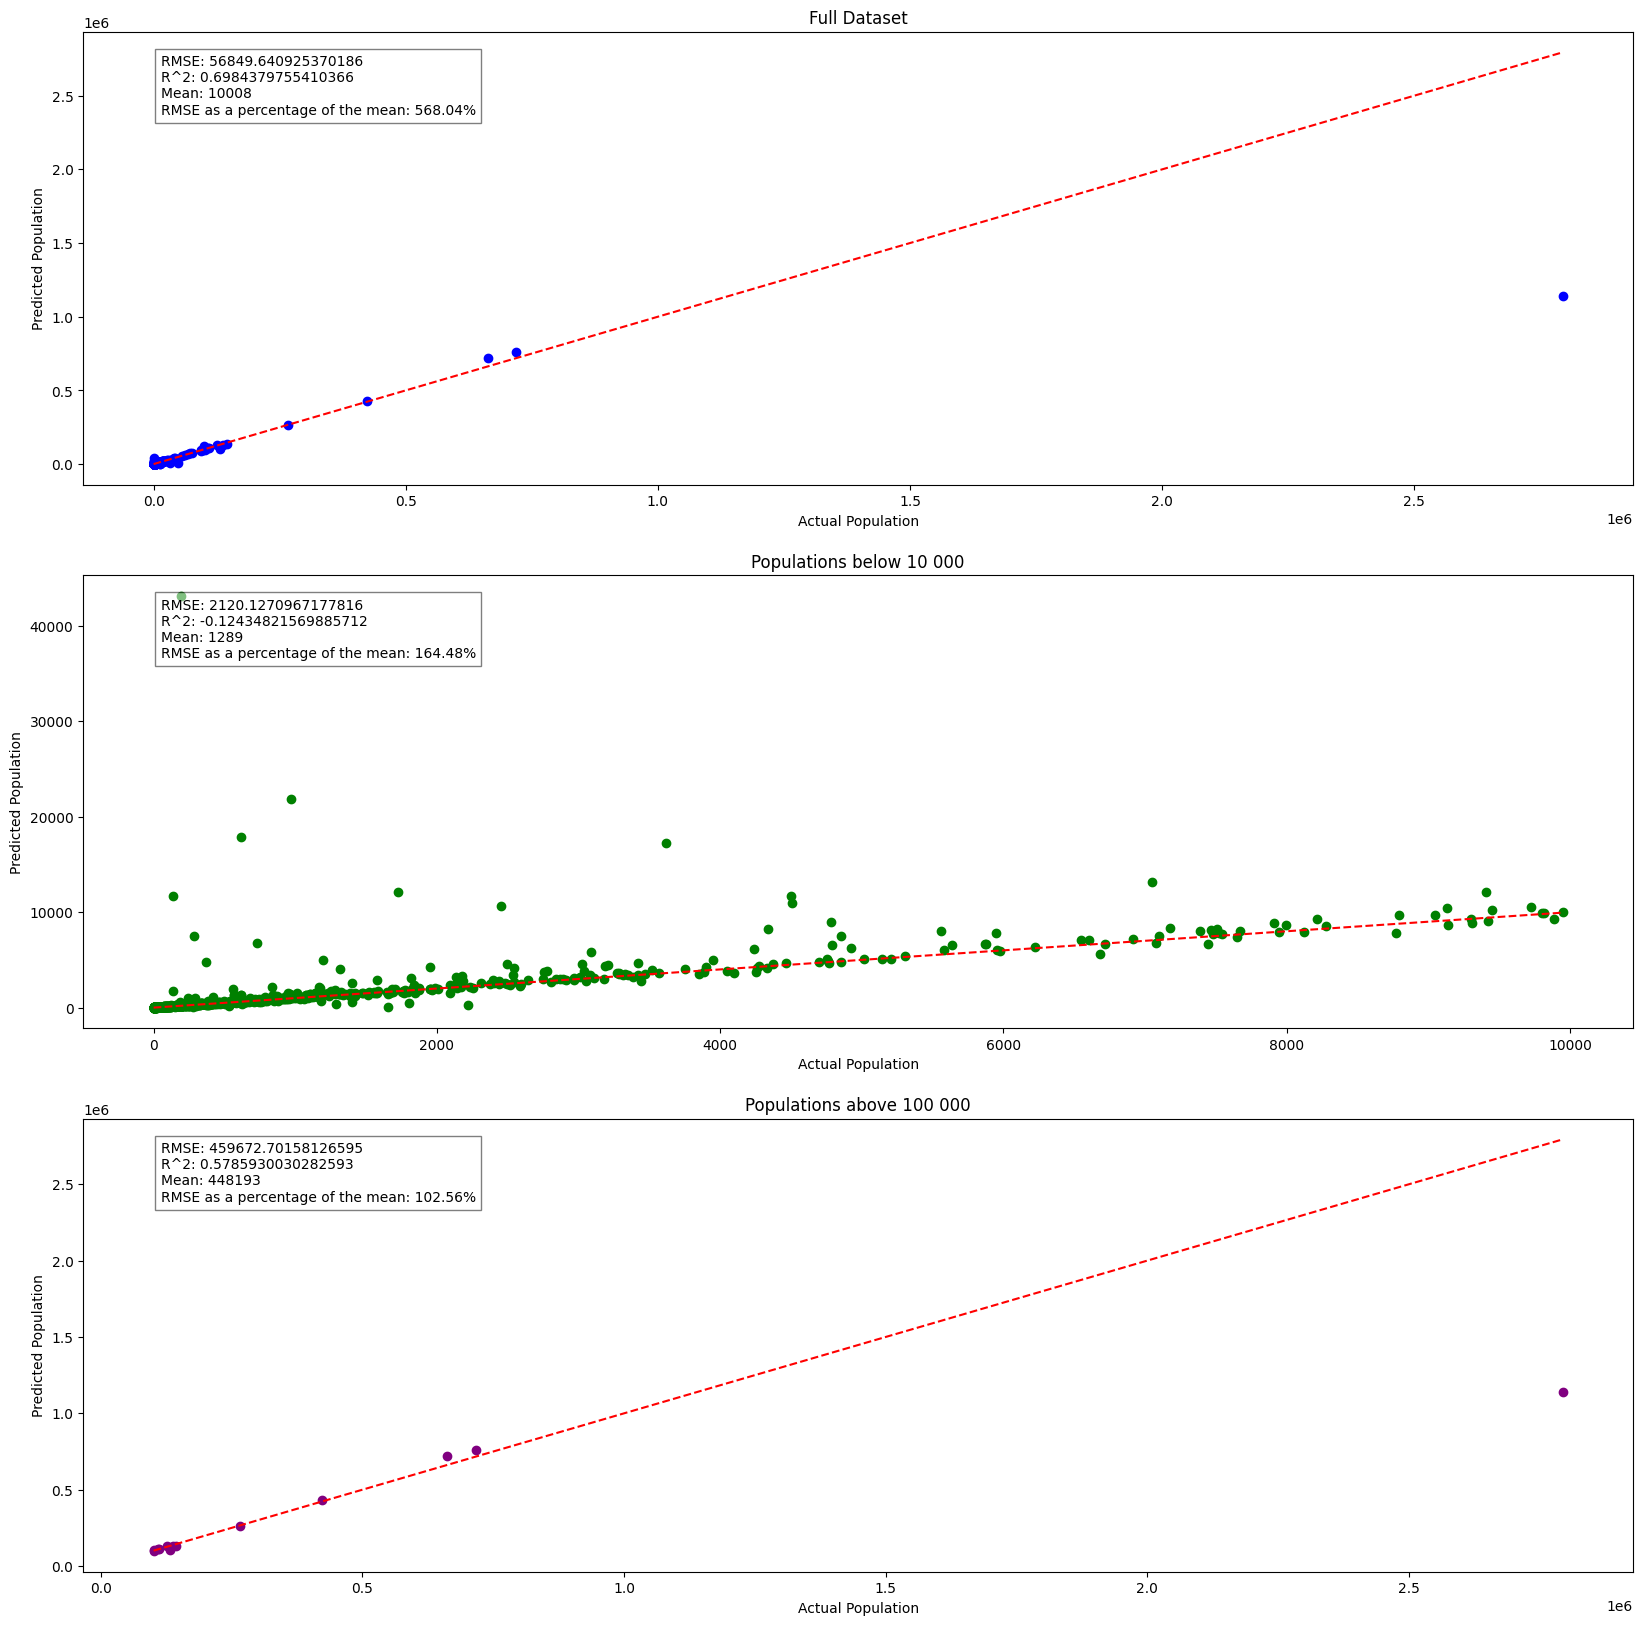

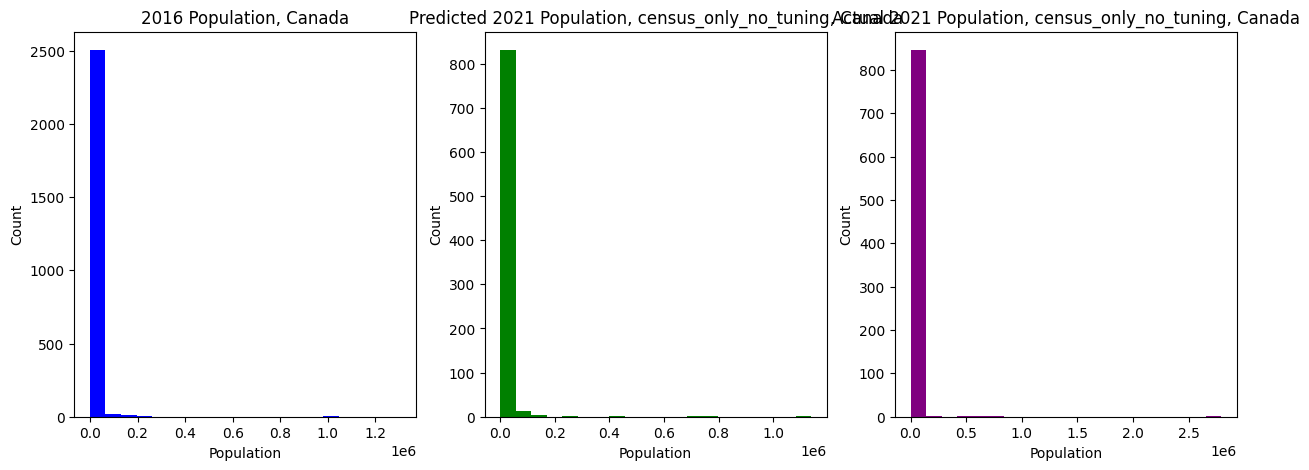

<Figure size 1000x500 with 0 Axes>

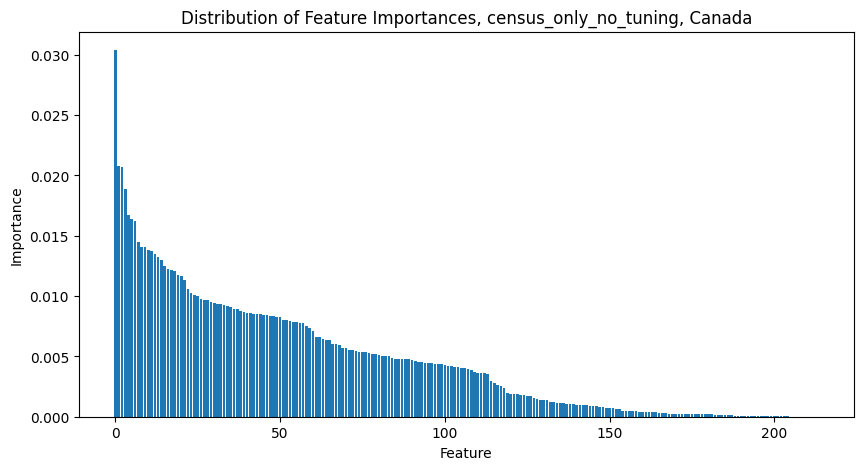

<Figure size 1000x1000 with 0 Axes>

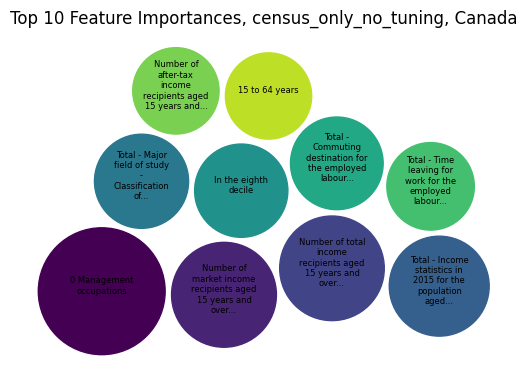

In [8]:
# We'll use our function to run the first analysis
modelAnalysis(yVal, yPred, 'census_only_no_tuning')

In [9]:
# Now let's see if we can do some hyperparameter tuning to get
# better prediction capabilities. We'll use a grid search to find the best
# number of trees and the best minimum samples per leaf

# Once again, we'll set up a function to handle the process
# so we can reuse it later

def hyperparameterTuning(model, features, targets):
    '''This function tunes the hyperparameters of a random forest regressor,
       given a set of features and target variables

    Args:
    features: The features to use for training (X)
    targets: The target variable for training (y)

    Returns:
    The best parameters found by the grid search
    '''
    paramGrid = {
        'regressor__n_estimators': [25, 50, 100, 200, 300, 400, 500],
        # 'regressor__n_estimators': [1, 2, 3, 4, 5], # for testing
        'regressor__min_samples_leaf': [1, 2, 4, 8, 16]
    }

    # We'll use the default 5-fold cross validation
    tuningStart = time.time()
    print('Starting hyperparameter tuning...')
    gridSearch = GridSearchCV(model, paramGrid)
    gridSearch.fit(features, targets)

    bestParams = gridSearch.best_params_
    bestScore = gridSearch.best_score_
    tuningEnd = time.time()
    print(f'Hyperparameter tuning complete. Time taken: {tuningEnd - tuningStart} seconds')
    print(f'Best parameters: {bestParams}')
    print(f'Best score: {bestScore}')

    bestTrees = bestParams['regressor__n_estimators']
    bestLeafSamples = bestParams['regressor__min_samples_leaf']
    return bestTrees, bestLeafSamples


In [10]:
# Let's retrain the model with the best parameters
bestTrees, bestLeafSamples = hyperparameterTuning(model, X, y)
bestModel, XTrainBest, XValBest, yTrainBest, yValBest, yPredBest, XBest, yBest = setupAndTraining(trimmed2016, trimmed2021, bestTrees, bestLeafSamples)

Starting hyperparameter tuning...


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Hyperparameter tuning complete. Time taken: 85.0263614654541 seconds
Best parameters: {'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 5}
Best score: 0.9133789197591466
Training model...
Model training complete. Training time: 1.2824978828430176 seconds
Predicting values...
Prediction complete

Validation RMSE: 55495.840096199194
Validation R^2: 0.7126295827417899
Mean of validation set: 7286
Validation RMSE as a percentage of the mean: 761.63%


0 Management occupations: 0.030400073152116788
Number of market income recipients aged 15 years and over in private households - 25% sample data: 0.02077878550615357
Number of total income recipients aged 15 years and over in private households - 25% sample data: 0.020668203813446362
Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data: 0.01886789903077509
Total - Major field of study - Classification of Instructional Programs (CIP) 2016 for the population aged 15 years and over in private households - 25% sample data: 0.01673642595886479
In the eighth decile: 0.016434252942896254
Total - Commuting destination for the employed labour force aged 15 years and over in private households with a usual place of work - 25% sample data: 0.016224334394594538
Total - Time leaving for work for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data: 0.

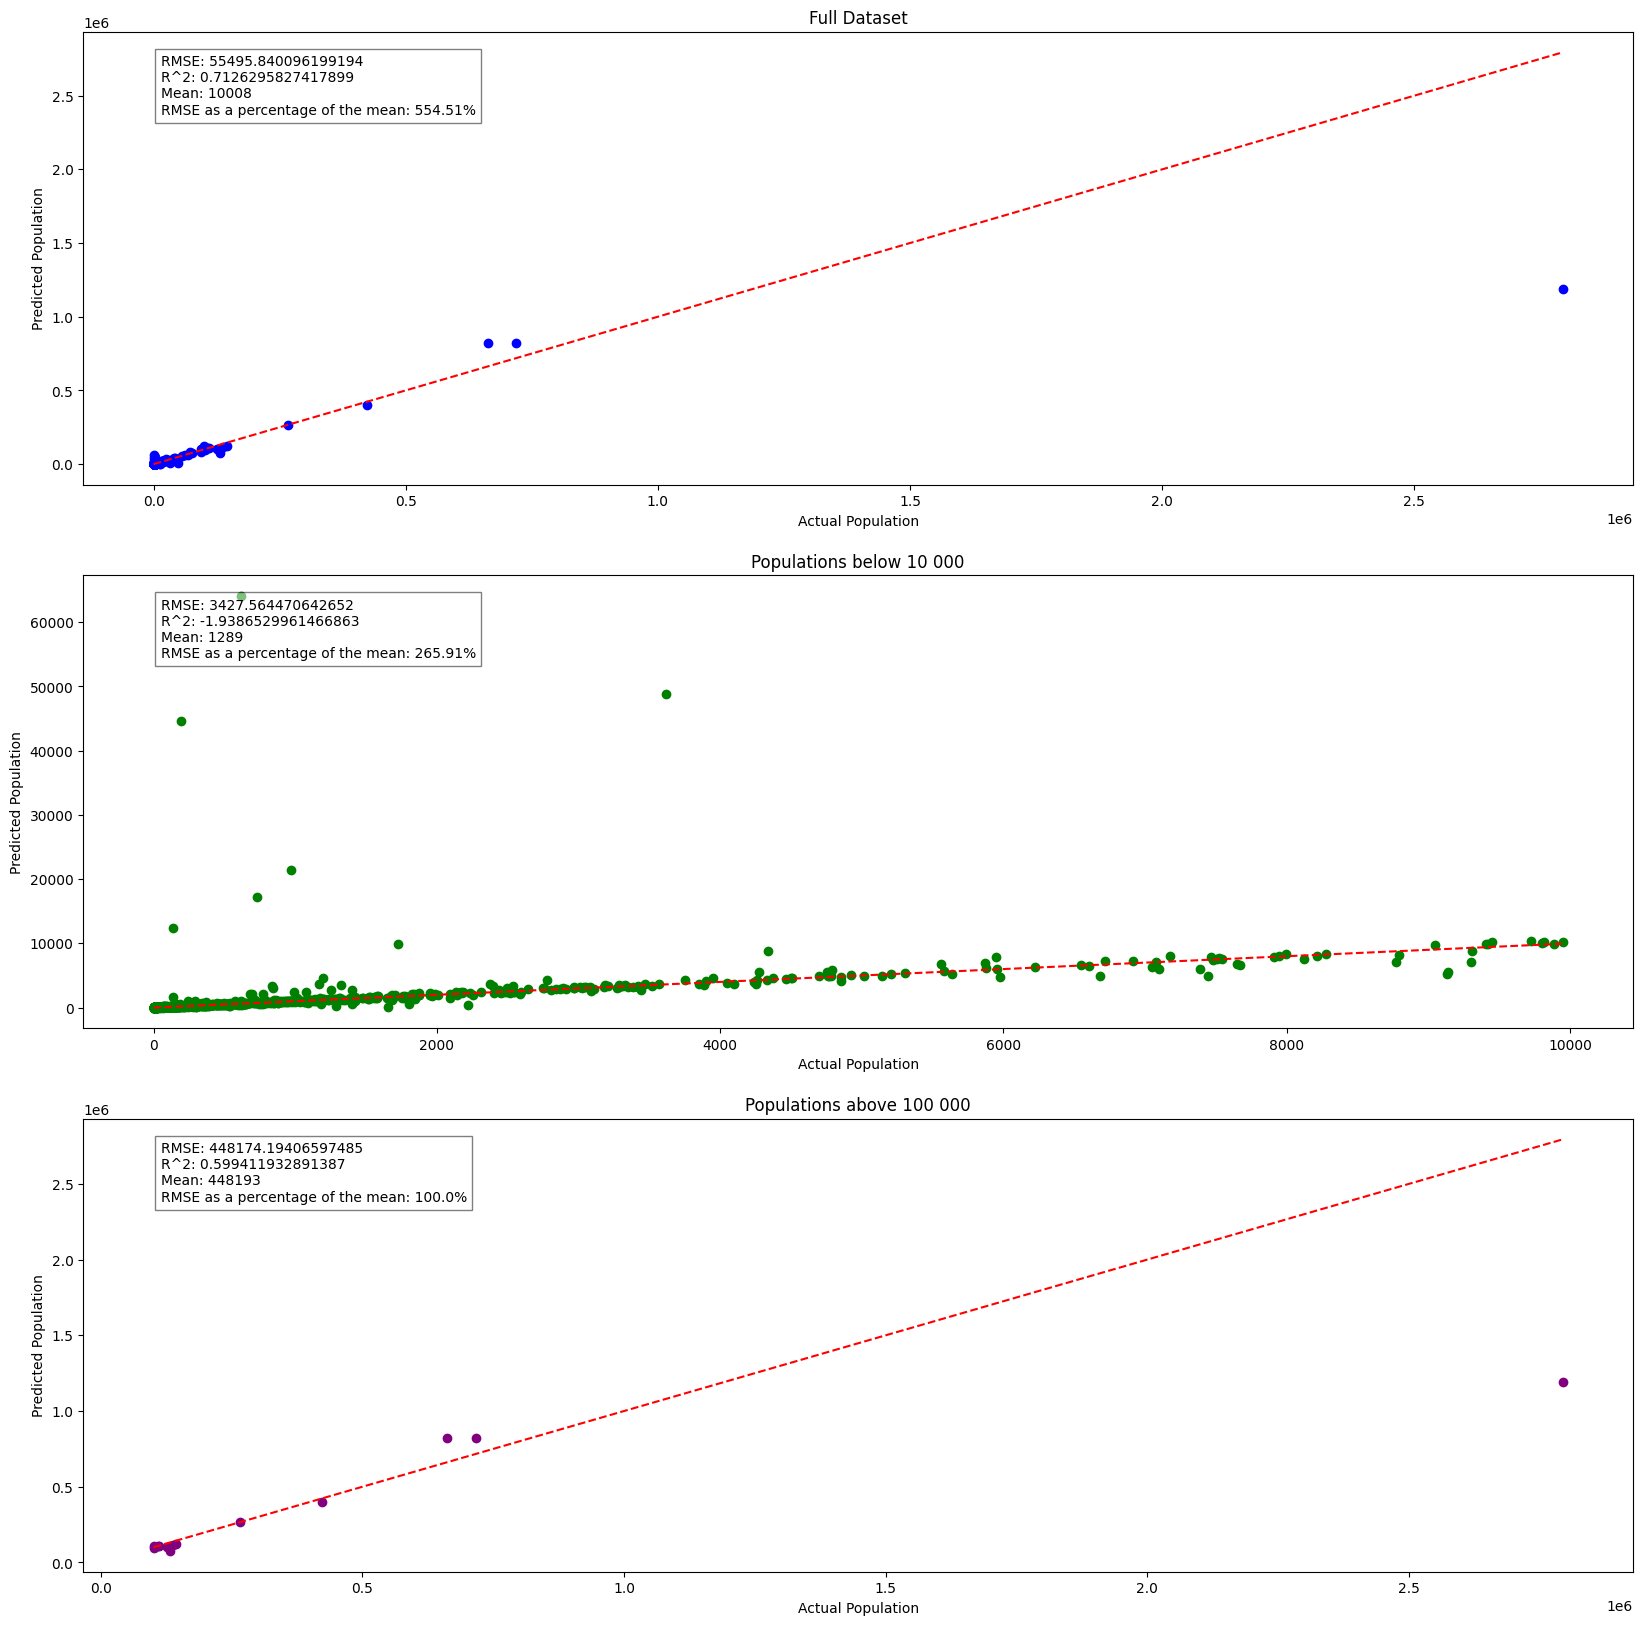

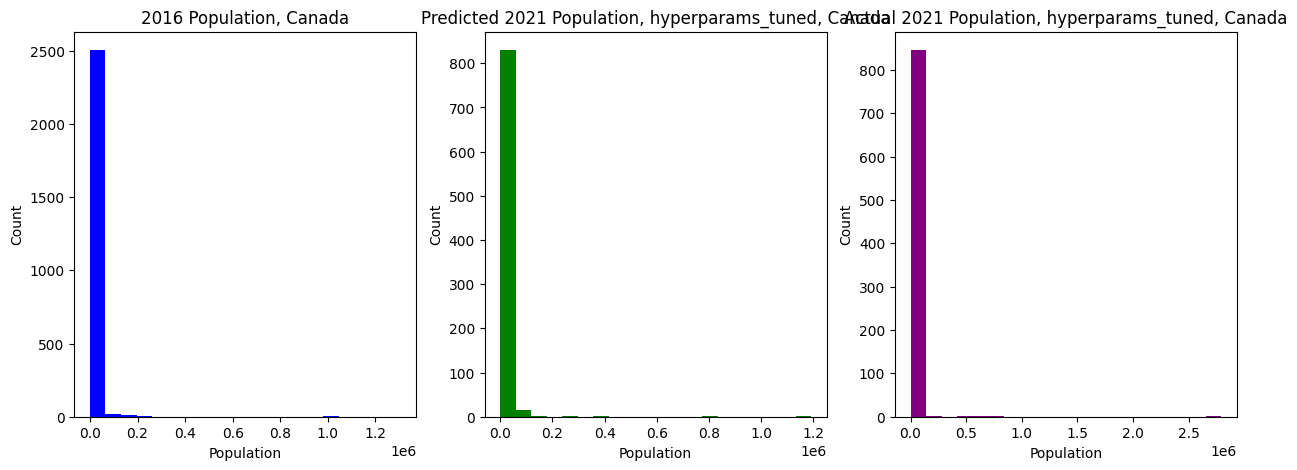

<Figure size 1000x500 with 0 Axes>

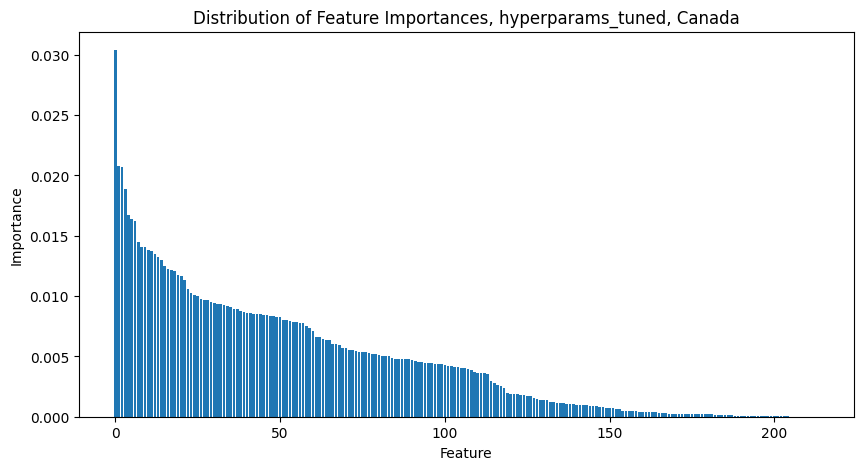

<Figure size 1000x1000 with 0 Axes>

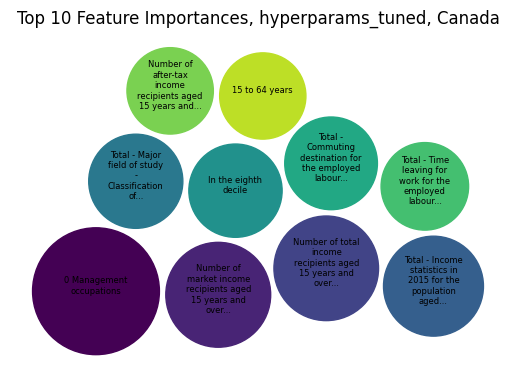

In [11]:
# We'll also run the model analysis again
modelAnalysis(yValBest, yPredBest, 'hyperparams_tuned')

In [13]:
# Let's save the model trained on the full Canada dataset using joblib
dump(bestModel, f'scriptOutputs/{dataSetName}_full_dataset_model.joblib')

['scriptOutputs/Canada_full_dataset_model.joblib']

In [17]:
# As a final experiment in training, let's see how the model performs
# when we repeat this process using only communities with populations below 100k
# This will allow us to see if the model performs better when it is not dealing with
# the extreme outliers (eg. Toronto, Vancouver, Montreal, etc.)

# First we will filter the original datasets
# We need to be careful when filtering because a community may have crossed the
# population threshold between 2016 and 2021. Let's filter the 2021 data first and
# use that to choose the 2016 data
below100k2021 = trimmed2021[trimmed2021['Population, 2021'] < 100000]
# Since the sets were ordered previously, we can use the index to filter the 2016 data
below100k2016 = trimmed2016.iloc[below100k2021.index]

# Print the length of both
print(f'2016 dataset length: {len(below100k2016)}')
print(f'2021 dataset length: {len(below100k2021)}')

2016 dataset length: 3360
2021 dataset length: 3360


Training model...
Model training complete. Training time: 1.1371369361877441 seconds
Predicting values...
Prediction complete

Validation RMSE: 1813.6367924303759
Validation R^2: 0.9711253319802932
Mean of validation set: 3186
Validation RMSE as a percentage of the mean: 56.93%
Starting hyperparameter tuning...
Hyperparameter tuning complete. Time taken: 74.50618100166321 seconds
Best parameters: {'regressor__min_samples_leaf': 8, 'regressor__n_estimators': 4}
Best score: 0.860566972109627
Training model...
Model training complete. Training time: 0.549999475479126 seconds
Predicting values...
Prediction complete

Validation RMSE: 2934.3309183897927
Validation R^2: 0.924415186806506
Mean of validation set: 3186
Validation RMSE as a percentage of the mean: 92.11%


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

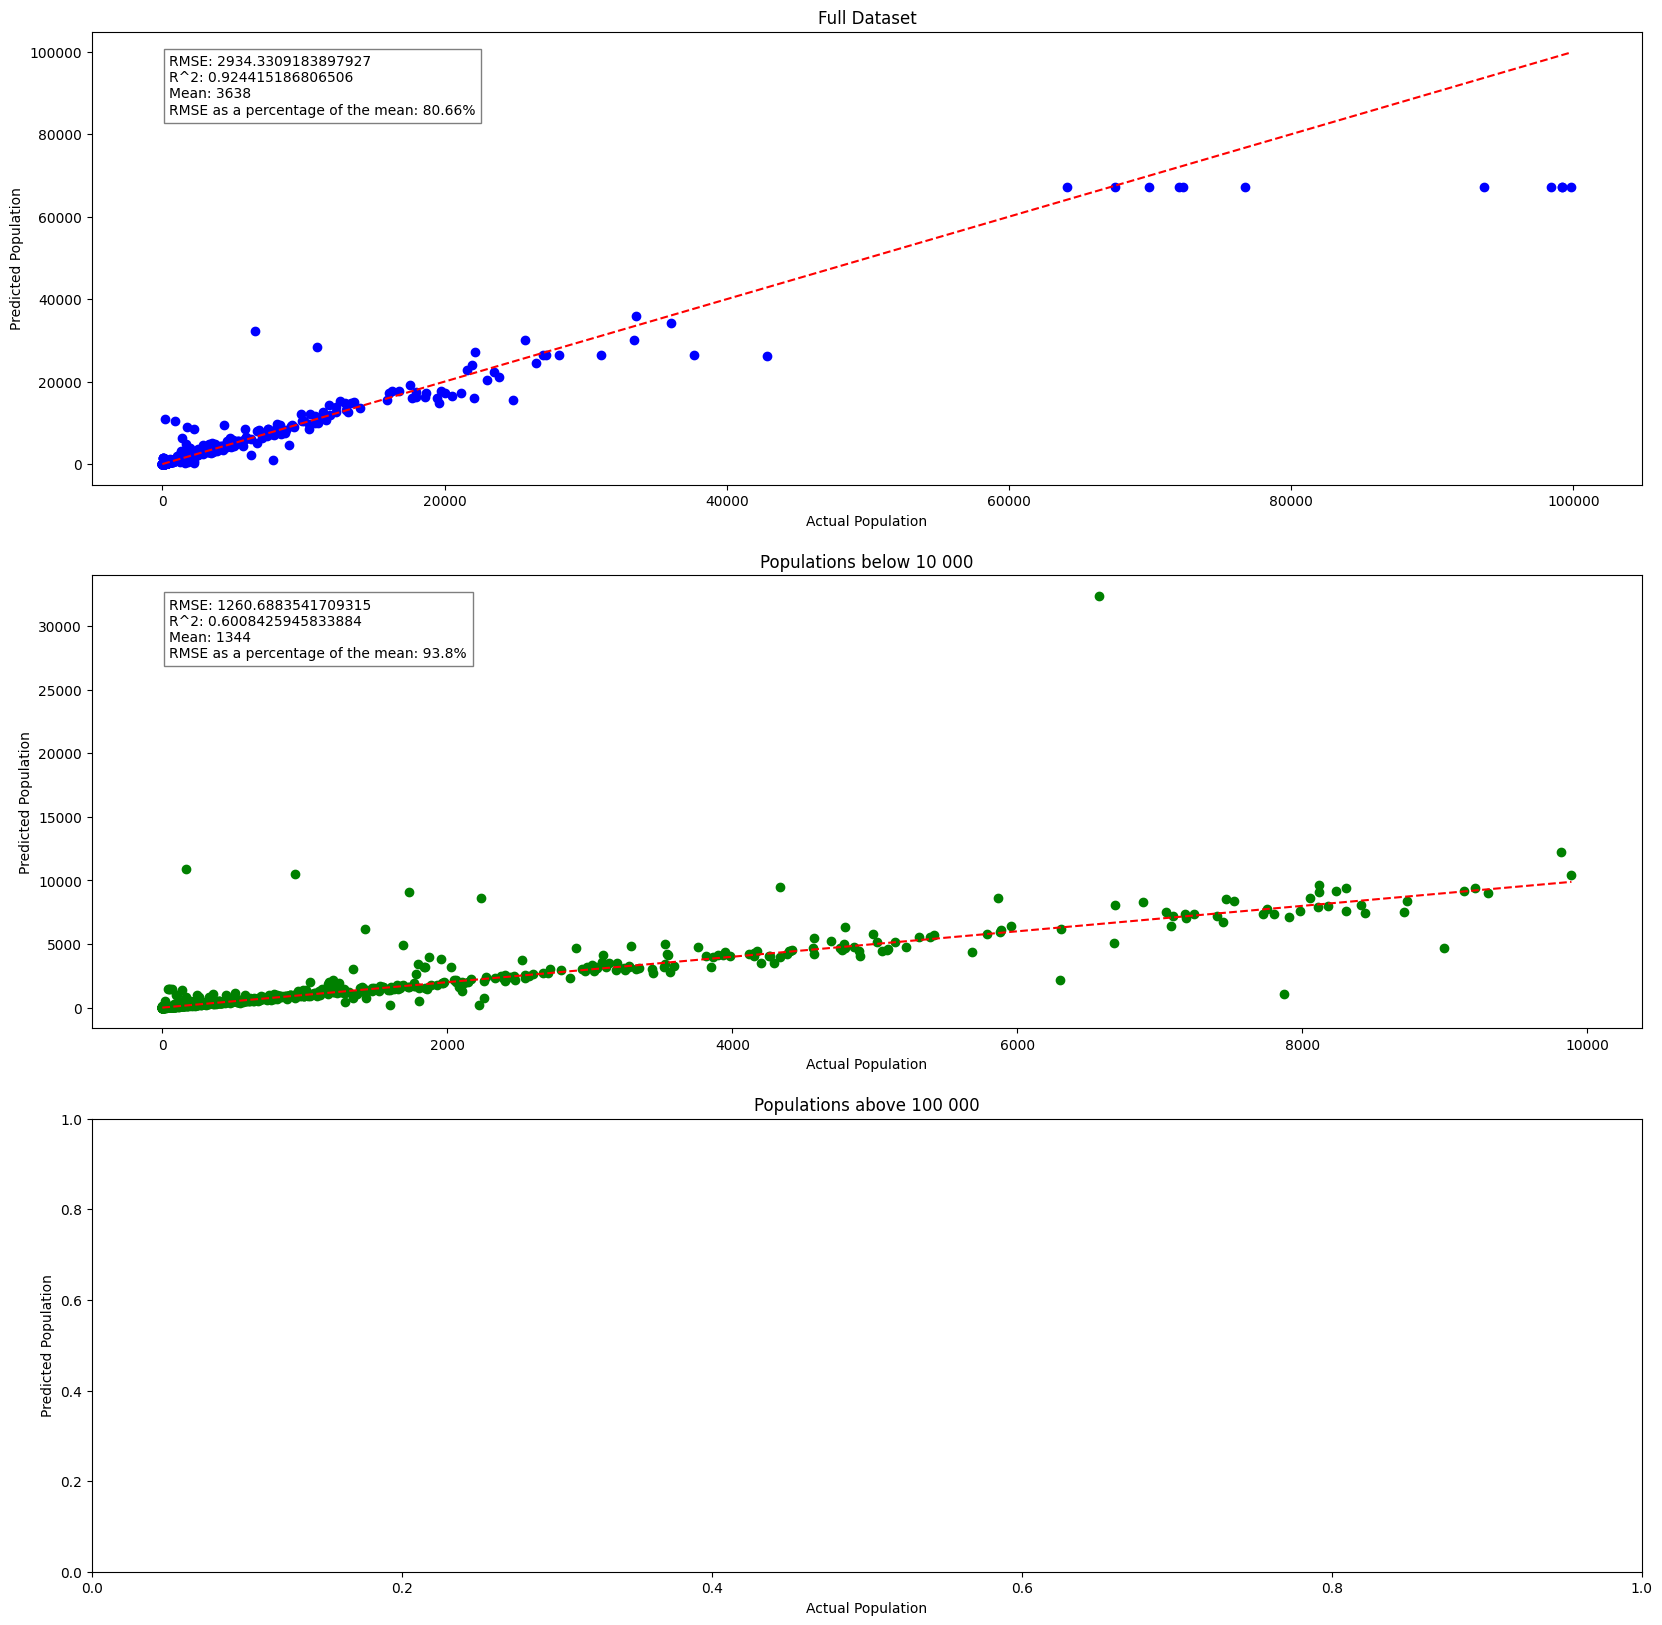

In [18]:
# Now we can train the model using the below 100k datasets
# We will train with function defaults, tune the hyperparameters again for this dataset, and then train again
# before we analyze the results
below100kModel, XTrain100k, XVal100k, yTrain100k, yVal100k, yPred100k, X100k, y100k = setupAndTraining(below100k2016, below100k2021, bestTrees, bestLeafSamples)
best100kTrees, best100kLeafSamples = hyperparameterTuning(below100kModel, X100k, y100k)
best100kModel, XTrain100kBest, XVal100kBest, yTrain100kBest, yVal100kBest, yPred100kBest, X100kBest, y100kBest = setupAndTraining(below100k2016, below100k2021, best100kTrees, best100kLeafSamples)
modelAnalysis(yVal100kBest, yPred100kBest, 'below_100k_tuned')

In [25]:
# Let's save this model as well, so we can compare them later
dump(best100kModel, f'scriptOutputs/{dataSetName}_below_100k_model.joblib')

['scriptOutputs/Canada_below_100k_model.joblib']